## Classification Fine-tuning

In [3]:
# #Imports
import urllib.request
import zipfile
import os
from pathlib import Path
from importlib.metadata import version
import pandas as pd
import tiktoken
import torch 
from torch.utils.data import Dataset, DataLoader

In [4]:
from importlib.metadata import version

pkgs = ["numpy", "torch", "transformers"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 1.24.3
torch version: 2.2.2
transformers version: 4.49.0


## Initialize a model with pretrained weights from the GPT2 model

In [5]:
from transformers import GPT2Model


# allowed model names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")
gpt_hf.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [6]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [7]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

In [8]:
import numpy as np


def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d["ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d["ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

In [9]:
import torch
from gpt2_functions import *


gpt = GPTModel(BASE_CONFIG)

device = "mps" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

In [10]:
import tiktoken
# from previous_chapters import generate, text_to_token_ids, token_ids_to_text

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


### Before fine-tuning the model,let's see if it already classifies spam messages by prompting it with instructions

In [11]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    "selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids(text_2, tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been speciallyselected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been speciallyselected to receive


### Download and prepare dataset

In [12]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path)/"SMSSpamCollection.tsv"

In [13]:
def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download"
              "and extraction.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read()) # Download the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path) # Unzip the file

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path) # adds a .tsv file extension
    print(f"File downloaded and saved as {data_file_path}") 

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)      


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping downloadand extraction.


In [14]:
# Load data into pandas df
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [16]:
# Create a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"]=="spam"].shape[0] #count spam instances
    ham_subset = df[df["Label"]=="ham"].sample(
        num_spam, random_state=123 #sample ham to match number of spam instances
    )
    balanced_df = pd.concat([ham_subset, df[df["Label"]=="spam"]])
    return balanced_df

In [17]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [18]:
for index, item in enumerate(list(df["Label"].unique())):
    print(index, item)
    print(df["Label"].unique()[index])
    


0 ham
ham
1 spam
spam


In [19]:
# Mapping function to convert string class labels to integer class labels, in this case 0, 1
mapping_dict = {item:index for (index, item) in enumerate(list(balanced_df["Label"].unique()))}
balanced_df["Label"] = balanced_df["Label"].map(mapping_dict)

In [20]:
balanced_df["Label"].value_counts()

Label
0    747
1    747
Name: count, dtype: int64

In [21]:
# Split the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True) #shuffle the entire df
    train_end = int(len(df)*train_frac) #calculate split indices
    validation_end = train_end + int(len(df)*validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [22]:
train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1) #train on 70%, validate on 10%, and test on the remaining 20%

In [23]:
# Save the dataset as a CSV file so we can reuse it later
train_df.to_csv("../data/spam_train.csv", index=None)
validation_df.to_csv("../data/spam_validation.csv", index=None)
test_df.to_csv("../data/spam_test.csv", index=None)

### Create data loaders
Pad all messages to the length of the longest message in the dataset in order to batch them

In [24]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]) #the token we will use for padding

50256


In [25]:
pad_token = "<|endoftext|>"
pad_token_ID = tokenizer.encode(pad_token, allowed_special={pad_token})[0]

In [26]:
# Set up Dataset which specifies *how* the data is *loaded* and *processed*
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256): 
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]] #"Text" is the column name for text
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length #truncate sequence if they're longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
        encoded_text + [pad_token_id] *
        (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
        ] # Pad sequences to a uniform length so input tensors are of the same size, necessary to create batches in the training data loader
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    def __len__(self):
        return len(self.data)
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length        
    

In [27]:
train_dataset = SpamDataset(
    csv_file="../data/spam_train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [28]:
print(train_dataset.max_length)

120


Note that the longest sequence is 120 tokens but hte model can handle up to 1024 tokens (context length).

In [29]:
# Pad the val and test sets to match the longest training sample sequence length. Anything longer is truncated
val_dataset = SpamDataset(
    csv_file="../data/spam_validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="../data/spam_test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

Instantiate data loaders (note that unlike pretraining on text data where target is the next token in the text, here its a class label)

In [30]:
# Data loaders in batch size=8, i.e. each bathc has 8 input text sequences
num_workers = 0
batch_size=8
torch.manual_seed(123)

train_loader = DataLoader(
dataset = train_dataset,
batch_size = batch_size,
shuffle = True,
num_workers = num_workers,
drop_last = True,
)
val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last = False,
)
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last = False
)


In [31]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


Each batch has 8 input sequences of size 120 tokens (purely the original sequence for the longest one , with padding for the shorter ones)
Let's print the total number of batches in the training, validation and test datasets

In [32]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### Add a Classification Head
Modifying the pretrained LLM (gpt) to prepare it for classication fine-tuning by replacing the original output layer with a smaller output layer that maps to two classes 0 and 1 for not spam and spam, respectively

In [33]:
# CHOOSE_MODEL = "gpt2-small (124M)"
# INPUT_PROMPT = "Every effort moves"

# BASE_CONFIG = {
#     "vocab_size": 50257,
#     "context_length": 1024,
#     "drop_rate": 0.0,
#     "qkv_bias": True
# }
# model_configs = {
#     "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
#     "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
#     "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
#     "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
# }
# BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [34]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

To get the model ready for fine-tuning, we'll first freeze the model, so that all the layers are non-trainable

In [35]:
for param in gpt.parameters():
    param.requires_grad = False

Next, we will replace the output layer (model.out_head) which originally maps the layer inputs to 50,257 dimensions, so it maps to 2 classes

In [36]:
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

By default, this new model head has its required_grad() set to True, which means it will be updated during training.
In addition, we will open up the last transformer block and the final LayerNorm which connects this block to the output layer, for training

In [37]:
for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in gpt.final_norm.parameters():
    param.requires_grad = True    

Examine this model set up

In [38]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Input dimensions:", inputs.shape) #shape:(batch_size, num_tokens)


Inputs: tensor([[5211,  345,  423,  640]])
Input dimensions: torch.Size([1, 4])


In [40]:
gpt = gpt.to(device)

In [41]:
# Pass the encoded token IDs to the model
with torch.no_grad():
    outputs = gpt(inputs.to(device))
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)    

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]], device='mps:0')
Outputs dimensions: torch.Size([1, 4, 2])


In [42]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]], device='mps:0')


### Calculating the classification loss and accuracy

In [43]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]], device='mps:0')


In [44]:
# logits = outputs[:, -1, :]
# print("Class label from logits:", torch.argmax(logits).item())
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())
print(type(label))

Class label: 1
<class 'torch.Tensor'>


In [45]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0,0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions/num_examples                    

In [46]:
# Compute classification accuracies estimated from 10 batches
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Prediction accuracies are near a random prediction (~50%). To improve predictions, we'll fine-tune them model.

In [54]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

#### Calculate the classification loss

In [57]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches              

In [58]:
# Compute the initial loss for each data set
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")   
print(f"Validation loss: {val_loss:.3f}") 
print(f"Test loss: {test_loss:.3f}")  

Training loss: 2.194
Validation loss: 2.583
Test loss: 2.322


In [52]:
len(train_loader)

130

### Fine-tuning the model on supervised data

In [78]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    #main training loop
    for epoch in range(num_epochs):
        model.train() #set the model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #reset loss gradient from the previous batch iteration
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward() #calculate loss gradient
            optimizer.step() #update model weights using loss gradients
            examples_seen += input_batch.shape[0] #track examples instead of tokens
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}"
                      f"Val loss {val_loss:.3f}"
                      )
                
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        ) 
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        ) 

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen          

            

In [79]:
#Evaluate model
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches = eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches = eval_iter
        )
    model.train()
    return train_loss, val_loss



In [80]:
#Initialize the optimizer, set number of training epochs, initiate training
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs=5

train_losses, val_losses, train_accs, val_accs, examples_seen =\
    train_classifier_simple(
        gpt, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )
end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 0.619Val loss 0.622
Ep 1 (Step 000050): Train loss 0.595Val loss 0.615
Ep 1 (Step 000100): Train loss 0.577Val loss 0.614
Training accuracy: 60.00% | Validation accuracy: 60.00%
Ep 2 (Step 000150): Train loss 0.623Val loss 0.610
Ep 2 (Step 000200): Train loss 0.597Val loss 0.589
Ep 2 (Step 000250): Train loss 0.593Val loss 0.581
Training accuracy: 77.50% | Validation accuracy: 80.00%
Ep 3 (Step 000300): Train loss 0.568Val loss 0.571
Ep 3 (Step 000350): Train loss 0.547Val loss 0.567
Training accuracy: 75.00% | Validation accuracy: 75.00%
Ep 4 (Step 000400): Train loss 0.474Val loss 0.568
Ep 4 (Step 000450): Train loss 0.557Val loss 0.547
Ep 4 (Step 000500): Train loss 0.551Val loss 0.540
Training accuracy: 90.00% | Validation accuracy: 82.50%
Ep 5 (Step 000550): Train loss 0.530Val loss 0.534
Ep 5 (Step 000600): Train loss 0.564Val loss 0.522
Training accuracy: 87.50% | Validation accuracy: 87.50%
Training completed in 8.28 minutes


### Plot classification loss

In [75]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.",
             label=f"Validation {label}"
             )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    #create a second x-axis for examples seen
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


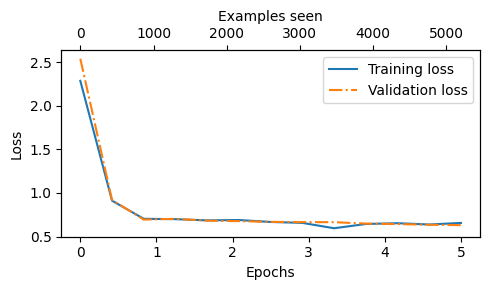

In [76]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses) 

The model has learned well from training data and there's no overfitting because there's no noticeable gap between training and validation set losses

#### Plot accuracy

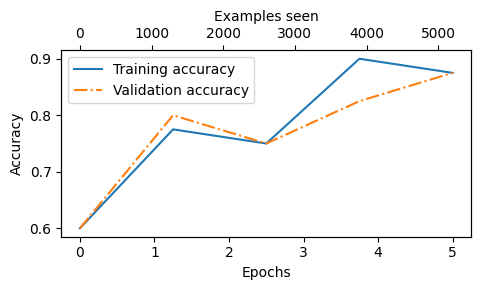

In [81]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

We estimated training and validation performance based on eval_iter, i.e. 5 batches, for efficiency during training. Let's compute performance metrics across the entire dataset (i.e. without defining the eval_iter value)

In [82]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

In [83]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 85.38%
Validation accuracy: 87.25%
Test accuracy: 85.00%


### Using the fine-tuned LLM as a spam classifier

In [84]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]
    input_ids += [pad_token_id]*(max_length - len(input_ids)) #pad seq to the longest seq

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0) #add batch dimension

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"    


In [85]:
text3 = ("You are a winner you have been specially"
         " selected to receive $1000 cash or a $2000 reward.")

print(classify_review(
    text3, gpt, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [86]:
text4 = ("Hey how have you been?"
         " Let's catch up soon!")

print(classify_review(
    text4, gpt, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [87]:
# Save fine-tuned model
torch.save(gpt.state_dict(), "review_classifier.pth")

In [91]:
# Example code to load the model
model_state_dict = torch.load("review_classifier.pth", map_location=device)
gpt.load_state_dict(model_state_dict)

<All keys matched successfully>